# Natural Language Processing
## Predict Yelp star ratings from review text

Unstructured data makes up the vast majority of data. This is a basic intro to handling unstructured data. The objective is to be able to extract the sentiment (positive or negative) from text. We will do this from Yelp reviews.

The model will be assessed based on how root mean squared error of the number of stars it predicts.

Download the data here : http://thedataincubator.s3.amazonaws.com/coursedata/mldata/yelp_train_academic_dataset_review.json.gz

### Load and parse the data
Load and parse the json using the `simplejson` library. Then convert it to a `pandas` data frame and remove columns I won't need to free up memory.

In [28]:
import re
import gzip
import nltk
import timeit
import simplejson
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import nltk.tokenize as tokenize
from sklearn import linear_model
from sklearn.externals import joblib
from sklearn import cross_validation, grid_search
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer

plt.style.use('ggplot')
%matplotlib inline
pd.options.display.max_columns=25

runit = 0

if runit:
    data = gzip.open('yelp_train_academic_dataset_review.json.gz')
    data_content = data.read()
    data.close()
    lines= re.split('\n',data_content)
    json_data = [simplejson.loads(line) for line in lines[:-1]]
    df = pd.DataFrame(json_data)
    del(json_data)
    df.info()

    ### all pasted code here on out
    cols_to_drop = ['date','review_id','type','user_id','votes']
    df.drop(cols_to_drop, axis=1, inplace=True)
    df.info()

    rows = np.random.choice(df.index.values,55000,replace=False)
    sampled_df = df.ix[rows]
    sampled_df.to_json('Yelp_review_text_stars_55000.json')
    del(df)
else:
    sampled_df = pd.read_json('Yelp_review_text_stars_55000.json')
    sampled_df.reset_index(drop=True,inplace=True)

sampled_df.head(5)

,business_id,stars,text
0,_wZTYYL7cutanzAnJUTGMA,3,We had dinner at the Beach House on Friday on ...
1,89O2bCyo92IpEEvgFXqOMw,5,Great cousins! The subs are always good and t...
2,n7G3zKFSgTrl2KE5HpzLcw,5,Had to get a smoothie after 3 hours of shoppin...
3,YZxA6w82eFJFntwqJLln6w,3,No cover for military. That's awesome and fre...
4,W6gPrnthBK7i1pe4ZZlJDQ,4,I don't understand why the ratings for this pl...


## Bag of Words
I will first build a bag of words model. I will build a linear model based on the count of the words in each review.

### Feature Extraction from Text
#### HashingVectorizer
I first need to tokenize the yelp reviews to break them into individual words. For this process I used the `nltk` package and the `HashingVectorizer` from `sklearn`. `HashingVectorizer` uses a hashtable to more efficiently store the large dictionary from the yelp reviews. 

One of the limitations of the `HashingVectorizer` is that is does not record the mapping: if you want to go back and forth that information is lost. However, I am concerned with a BagOfWords model to predict rating stars.  I don't care what words predict 5 stars: `HashingVectorizer` will suffice.

#### Stopwords
Common english language words were filtered using a `nltk` subpackage and the `stopwords` parameter in `HashingVectorizer`. Stop words are words we want to omit because they are common and do not tend to give us any value as to the meaning of reviews. Example of stop words are: "a", "an", "the", "it", "he", "her". 

#### Lemmatization
I also found it necessary to use word lemmatization. Lemmatization is an NLP strategy to lower the vocabulary space by combining words that have the same root. For example, in English, the verb 'to jump' may appear as 'jump', 'jumped', 'jumps', 'jumping'. The base form, 'jump', that one might look up in a dictionary, is called the *lemma* for the word. I use `nltk`'s `WordNetLemmatizer`.

In [29]:
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

Setup the test and training data sets.

In [30]:
text_train,text_test,stars_train,stars_test = cross_validation.train_test_split(sampled_df['text'],sampled_df['stars'],
                                                                               test_size=0.2, random_state=23)


#### Model Fitting

I use `SGDRegressor`, which implements a plain stochastic gradient descent learning routine, to fit my bag of words model to the star rating on Yelp. It is well suited for regression problems with a large number of training samples (> 10000). Cross validation was used to validate the test set and prevent overfitting.

The `Pipeline` function of sklearn was used to quickly and easily link preprocessing (`HashingVectorizer`) and estimator (`SGDRegressor`) steps of my machine learning model.

#### N-grams of size 1
I will use a ngram size of one for the first model. Only single words are hashed.

In [31]:
if runit:
    hv_mono = HashingVectorizer(tokenizer=LemmaTokenizer(),norm='l2',ngram_range=(1,1),stop_words=nltk.corpus.stopwords.words('english'))
    hv_mono_counts = hv_mono.fit_transform(sampled_df['text'])
    joblib.dump(hv_mono,'hash_vectorizer_mono.pkl')
    del(hv_mono_counts)
    #fit model
    tic=timeit.default_timer()
    monogram_pipeline = Pipeline([
    ('vect', hv_mono),
    ('lm', linear_model.SGDRegressor(n_iter=6000,alpha=.00001,penalty='l2')),
    ])
    monogram_pipeline.fit(text_train,stars_train)
    toc=timeit.default_timer()
    print toc - tic
    joblib.dump(monogram_pipeline,'monogram_pipeline.pkl')
else:
    nv_mono = joblib.load('hash_vectorizer_mono.pkl')
    monogram_pipeline=joblib.load('monogram_pipeline.pkl')

score = monogram_pipeline.score(text_test,stars_test)
print 'Monogram score: ', score

Monogram score:  0.620905936123


The score above is the coefficient of determination R^2 of the prediction. So 62% of the variannce in star rating is predictable from monograms of the review text. Let's look at how these predictions line up with the actual data.

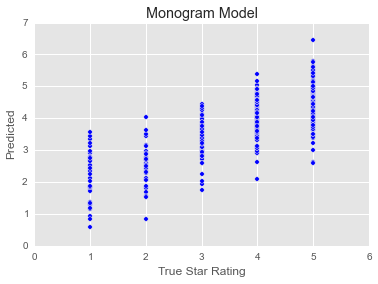

In [37]:
plt.scatter(stars_test[:500],monogram_pipeline.predict(text_test[:500]),)
plt.xlabel('True Star Rating')
plt.ylabel('Predicted')
plt.title('Monogram Model')

#### N-grams of size 2
I will use a ngram size of one for the next model. These bigrams are two adjacent words from the text.

In [36]:
if runit:
    hv_bi = HashingVectorizer(tokenizer=LemmaTokenizer(),norm='l2',ngram_range=(2,2),stop_words=nltk.corpus.stopwords.words('english'))
    hv_bi_counts = hv_bi.fit_transform(sampled_df['text'])
    joblib.dump(hv_bi,'hash_vectorizer_bi.pkl')
    del(hv_bi_counts)
    #fit model
    tic=timeit.default_timer()
    bigram_pipeline = Pipeline([
    ('vect', hv_bi),
    ('lm', linear_model.SGDRegressor(n_iter=6000,alpha=.00001,penalty='l2')),
    ])
    bigram_pipeline.fit(text_train,stars_train)
    toc=timeit.default_timer()
    print toc - tic
    joblib.dump(bigram_pipeline,'bigram_pipeline.pkl')
else:
    hv_bi = joblib.load('hash_vectorizer_bi.pkl')
    bigram_pipeline=joblib.load('bigram_pipeline.pkl')

score = bigram_pipeline.score(text_test,stars_test)
print 'Bigram score: ', score

Bigram score:  0.745359651404


Bigrams do not do better than monograms. Let's plot these predictions.

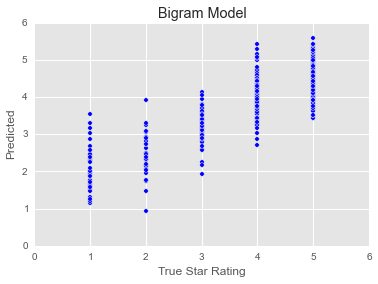

In [39]:
plt.scatter(stars_test[:500],bigram_pipeline.predict(text_test[:500]),)
plt.xlabel('True Star Rating')
plt.ylabel('Predicted')
plt.title('Bigram Model')

In [40]:
if runit:
    hv_monobi = HashingVectorizer(tokenizer=LemmaTokenizer(),norm='l2',ngram_range=(1,2),stop_words=nltk.corpus.stopwords.words('english'))
    hv_monobi_counts = hv_monobi.fit_transform(sampled_df['text'])
    joblib.dump(hv_monobi,'hash_vectorizer_monobi.pkl')
    del(hv_monobi_counts)
    #fit model
    tic=timeit.default_timer()
    monobi_pipeline = Pipeline([
    ('vect', hv_monobi),
    ('lm', linear_model.Ridge()),
    ])
    monobi_pipeline.fit(text_train,stars_train)
    toc=timeit.default_timer()
    print toc - tic
    joblib.dump(monobi_pipeline,'monobi_pipeline.pkl')
else:
    hv_monobi = joblib.load('hash_vectorizer_monobi.pkl')
    monobi_pipeline=joblib.load('monobi_pipeline.pkl')
    
score = monobi_pipeline.score(text_test,stars_test)
print 'Bi- and Monogram score: ', score

Bi- and Monogram score:  0.737116961314


The bi- and mono-gram model does not perform better than the bigram model.

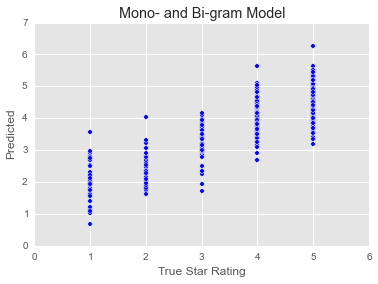

In [41]:
plt.scatter(stars_test[:500],monobi_pipeline.predict(text_test[:500]),)
plt.xlabel('True Star Rating')
plt.ylabel('Predicted')
plt.title('Mono- and Bi-gram Model')

In [42]:
tic=timeit.default_timer()
if runit:
    pred_mono_train = monogram_pipeline.predict(text_train)
    pred_bi_train = bigram_pipeline.predict(text_train)
    pred_combined_train = [[p1,p2] for p1,p2 in zip(pred_mono_train,pred_bi_train)]
    lm = linear_model.LinearRegression(normalize=True,n_jobs=2)
    lm.fit(pred_combined_train,stars_train)
    joblib.dump(lm,'LM_monobi.pkl')
else:
    lm = joblib.load('LM_monobi.pkl')

pred_mono_test = monogram_pipeline.predict(text_test)
pred_bi_test = bigram_pipeline.predict(text_test)
pred_combined_test = [[p1,p2] for p1,p2 in zip(pred_mono_test,pred_bi_test)]
score = lm.score(pred_combined_test,stars_test)
print 'Bi- and Monogram Linear Regression score: ', score
toc=timeit.default_timer()
print toc - tic

Bi- and Monogram Linear Regression score:  0.764468788678
439.277779726


In [43]:
joblib.dump(lm,'LM_monobi.pkl')

['LM_monobi.pkl', 'LM_monobi.pkl_01.npy', 'LM_monobi.pkl_02.npy']

The linear model of the predictions 

In [ ]:
plt.scatter(stars_test[:500],lm.predict(text_test[:500]),)
plt.xlabel('True Star Rating')
plt.ylabel('Predicted')
plt.title('Mono- and Bi-gram Linear Model Model')

In [26]:
if runit = 0:
nv_mono = joblib.load('hash_vectorizer_mono.pkl')
hv_bi = joblib.load('hash_vectorizer_bi.pkl')
hv_monobi = joblib.load('hash_vectorizer_monobi.pkl')
monogram_pipeline=joblib.load('monogram_pipeline.pkl')
bigram_pipeline=joblib.load('bigram_pipeline.pkl')
monobi_pipeline=joblib.load('monobi_pipeline.pkl')

text_train,text_test,stars_train,stars_test = cross_validation.train_test_split(sampled_df['text'],sampled_df['stars'],
                                                                               test_size=0.2, random_state=23)

score = monogram_pipeline.score(text_test,stars_test)
print 'Monogram score: ', score
score = bigram_pipeline.score(text_test,stars_test)
print 'Bigram score: ', score
score = monobi_pipeline.score(text_test,stars_test)
print 'Bi- and Monogram score: ', score

'''
tic=timeit.default_timer()
monogram_pipeline = Pipeline([
('vect', hv_mono),
('lm', linear_model.SGDRegressor(n_iter=6000,alpha=.00001,penalty='l2')),
])
monogram_pipeline.fit(text_train,stars_train)
score = monogram_pipeline.score(text_test,stars_test)
print 'Monogram score: ', score
toc=timeit.default_timer()
print toc - tic
joblib.dump(monogram_pipeline,'monogram_pipeline.pkl')

tic=timeit.default_timer()
bigram_pipeline = Pipeline([
('vect', hv_bi),
('lm', linear_model.SGDRegressor(n_iter=6000,alpha=.00001,penalty='l2')),
])
bigram_pipeline.fit(text_train,stars_train)
score = bigram_pipeline.score(text_test,stars_test)
print 'Bigram score: ', score
toc=timeit.default_timer()
print toc - tic
joblib.dump(bigram_pipeline,'bigram_pipeline.pkl')

tic=timeit.default_timer()
pred_mono_train = monogram_pipeline.predict(text_train)
pred_bi_train = bigram_pipeline.predict(text_train)
pred_combined_train = [[p1,p2] for p1,p2 in zip(pred_mono_train,pred_bi_train)]
lm = linear_model.LinearRegression(normalize=True,n_jobs=2)
lm.fit(pred_combined_train,stars_train)

pred_mono_test = monogram_pipeline.predict(text_test)
pred_bi_test = bigram_pipeline.predict(text_test)
pred_combined_test = [[p1,p2] for p1,p2 in zip(pred_mono_test,pred_bi_test)]
score = lm.score(pred_combined_test,stars_test)
print 'Bi- and Monogram Linear Regression score: ', score
toc=timeit.default_timer()
print toc - tic

tic=timeit.default_timer()
monobi_pipeline = Pipeline([
('vect', hv_monobi),
('lm', linear_model.Ridge()),
])
monobi_pipeline.fit(text_train,stars_train)
score = monobi_pipeline.score(text_test,stars_test)
print 'Bi- and Monogram score: ', score
toc=timeit.default_timer()
print toc - tic
joblib.dump(monobi_pipeline,'monobi_pipeline.pkl')
'''


Monogram score:  0.620905936123
Bigram score:  0.745359651404
Bi- and Monogram score:  0.737116961314


"\ntic=timeit.default_timer()\nmonogram_pipeline = Pipeline([\n('vect', hv_mono),\n('lm', linear_model.SGDRegressor(n_iter=6000,alpha=.00001,penalty='l2')),\n])\nmonogram_pipeline.fit(text_train,stars_train)\nscore = monogram_pipeline.score(text_test,stars_test)\nprint 'Monogram score: ', score\ntoc=timeit.default_timer()\nprint toc - tic\njoblib.dump(monogram_pipeline,'monogram_pipeline.pkl')\n\ntic=timeit.default_timer()\nbigram_pipeline = Pipeline([\n('vect', hv_bi),\n('lm', linear_model.SGDRegressor(n_iter=6000,alpha=.00001,penalty='l2')),\n])\nbigram_pipeline.fit(text_train,stars_train)\nscore = bigram_pipeline.score(text_test,stars_test)\nprint 'Bigram score: ', score\ntoc=timeit.default_timer()\nprint toc - tic\njoblib.dump(bigram_pipeline,'bigram_pipeline.pkl')\n\ntic=timeit.default_timer()\npred_mono_train = monogram_pipeline.predict(text_train)\npred_bi_train = bigram_pipeline.predict(text_train)\npred_combined_train = [[p1,p2] for p1,p2 in zip(pred_mono_train,pred_bi_train)]

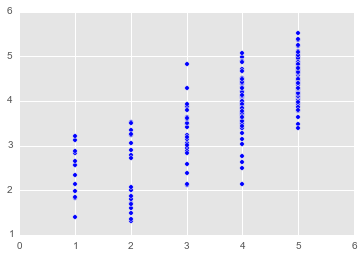

In [24]:
plt.scatter(stars_test[:200],monobi_pipeline.predict(text_test[:200]),)

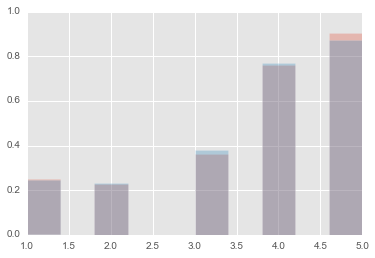

In [15]:
stars_train.hist( alpha=0.3 ,stacked=False,normed=True)
stars_test.hist( alpha=0.3 ,stacked=False,normed=True)

In [17]:
rows = np.random.choice(df.index.values,33000,replace=False)
sampled_df = df.ix[rows]
sampled_df.to_json('Yelp_review_text_stars_33000.json')
del(df)

In [18]:
hv = HashingVectorizer(norm='l2',stop_words=nltk.corpus.stopwords.words('english'))
hvcounts = hv.fit_transform(sampled_df['text'])

In [6]:
#joblib.dump(hv,'hash_vectorizer.pkl') Saved hv from full data
#joblib.dump(hvcounts,'hvcounts.pkl') Saved hvcounts from full data

['hvcounts.pkl',
 'hvcounts.pkl_01.npy',
 'hvcounts.pkl_02.npy',
 'hvcounts.pkl_03.npy']

In [60]:
text_train,text_test,stars_train,stars_test = cross_validation.train_test_split(sampled_df['text'],sampled_df['stars'],
                                                                               test_size=0.2, random_state=23)

In [61]:
tic=timeit.default_timer()

monogram_pipeline = Pipeline([
('vect', HashingVectorizer(norm='l2',ngram_range=(1,1),stop_words=nltk.corpus.stopwords.words('english'))),
('lm', linear_model.SGDRegressor(n_iter=6000,alpha=.00001,penalty='l2')),
])

monogram_pipeline.fit(text_train,stars_train)
score = monogram_pipeline.score(text_test,stars_test)
print 'Monogram score: ', score

toc=timeit.default_timer()
print toc - tic

Monogram score:  0.565108558564
154.448280271


In [62]:
tic=timeit.default_timer()

bigram_pipeline = Pipeline([
('vect', HashingVectorizer(norm='l2',ngram_range=(2,2),stop_words=nltk.corpus.stopwords.words('english'))),
('lm', linear_model.SGDRegressor(n_iter=6000,alpha=.00001,penalty='l2')),
])

bigram_pipeline.fit(text_train,stars_train)
score = bigram_pipeline.score(text_test,stars_test)
print 'Bigram score: ', score

toc=timeit.default_timer()
print toc - tic

Bigram score:  0.413075315485
213.984861767


In [67]:
text_train,text_test,stars_train,stars_test = cross_validation.train_test_split(sampled_df['text'],sampled_df['stars'],
                                                                               test_size=0.2, random_state=23)
tic=timeit.default_timer()

pred_mono_train = monogram_pipeline.predict(text_train)
pred_bi_train = bigram_pipeline.predict(text_train)
pred_combined_train = [[p1,p2] for p1,p2 in zip(pred_mono_train,pred_bi_train)]
lm = linear_model.LinearRegression(normalize=True,n_jobs=2)
lm.fit(pred_combined_train,stars_train)

pred_mono_test = monogram_pipeline.predict(text_test)
pred_bi_test = bigram_pipeline.predict(text_test)
pred_combined_test = [[p1,p2] for p1,p2 in zip(pred_mono_test,pred_bi_test)]
score = lm.score(pred_combined_test,stars_test)
print 'Bi- and Monogram Linear Regression score: ', score

toc=timeit.default_timer()
print toc - tic

Bi- and Monogram Linear Regression score:  0.445895681409
37.2129645705


In [63]:
tic=timeit.default_timer()

monobi_pipeline = Pipeline([
('vect', HashingVectorizer(ngram_range=(1,2),norm='l2',stop_words=nltk.corpus.stopwords.words('english'))),
('lm', linear_model.SGDRegressor(n_iter=6000,penalty='l2',alpha=.00001)),
])
monobi_pipeline.fit(text_train,stars_train)
score = monobi_pipeline.score(text_test,stars_test)
print 'Bi- and Monogram score: ', score

toc=timeit.default_timer()
print toc - tic

Bi- and Monogram score:  0.581969293554
314.762666724


In [68]:
tic=timeit.default_timer()

monobi_pipeline = Pipeline([
('vect', HashingVectorizer(ngram_range=(1,2),norm='l2',stop_words=nltk.corpus.stopwords.words('english'))),
('lm', linear_model.Ridge()),
])
monobi_pipeline.fit(text_train,stars_train)
score = monobi_pipeline.score(text_test,stars_test)
print 'Bi- and Monogram score: ', score

toc=timeit.default_timer()
print toc - tic

Bi- and Monogram score:  0.580045386659
23.8673929312


A simple linear regression combining a model trained on monograms and a model trained on bigrams has a stronger predictive power than either alone!

This combined model beat the benchmark for a bigram model on the Heroku app.

### Top restaurant bigrams

Looking at only reviews of restaurants I next wanted to identify word pairs in reviews that are more likely than the individual words alone. These might be strongly indicative of "foodie" type words that you might expect to find in a yelp review such as "huevos rancheros".

We can find word pairs that are unlikely to occur consecutively based on the underlying probability of their words.

Mathematically, if $p(w)$ be the probability of a word w and $p(w1w2)$ is the probability of the bigram $w1w2$, then we want to look at word pairs $w1w2$ where the statistic

$p(w1w2)/p(w1)/p(w2)$

is high.

This metric is, however, problematic when $p(w_1)$ and/or $p(w_2)$ are small. This can be fixed with Bayesian smoothing or additive smoothing which essentially adds a constant factor to all probabilities. This factor sets the scale for the number of appearances a word must be used in the overall corpus before it is considered relevent.

First I need to load in a second data set that idenitifies which businesses are restaurants and do an SQL style join on my two pandas dataframes. This will allow me to select reviews that only correspond to restaurants and by extension special food bigrams.

In [69]:
data = gzip.open('../ML_Yelp_BusFeatures/yelp_train_academic_dataset_business.json.gz')
data_content_biz = data.read()
data.close()
lines= re.split('\n',data_content_biz)
json_data = [simplejson.loads(line) for line in lines[:-1]]
dfbiz = pd.DataFrame(json_data)

restaurant = []
for i in dfbiz.index:
    restaurant.append(sum([1 for cat in dfbiz.iloc[i]['categories'] if re.match('Restaurants',cat)]))
dfbiz['restaurant'] = restaurant
df_big = pd.merge(sampled_df,dfbiz,on='business_id')
df_rest = df_big[df_big['restaurant']==1]

In [70]:
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

CountVectorizer

Previously I used HashingVectorizer to take advantage of its smaller pickle sizes for Heroku deployment. As discussed before, HashingVectorizer cannot give you backward compatibility: you lose what word corresponds to what index. Since I now want to know what the words are, I switched over to CountVectorizer.

In [71]:
cvbi = CountVectorizer(tokenizer=LemmaTokenizer(),ngram_range=(2,2),stop_words=nltk.corpus.stopwords.words('english'))
bi = cvbi.fit_transform(df_rest['text'])
cvmono = CountVectorizer(tokenizer=LemmaTokenizer(),ngram_range=(1,1),stop_words=nltk.corpus.stopwords.words('english'))
mono = cvmono.fit_transform(df_rest['text'])
bi_keys = cvbi.vocabulary_.keys() #[key for key in cvbi.vocabulary_.keys() if not re.match('.*[0-9_-].*',key)]
mono_keys = cvmono.vocabulary_.keys() #[key for key in cvmono.vocabulary_.keys() if not re.match('.*[0-9_-].*',key)]
bi_keys_split = [re.split('\s',key) for key in bi_keys]

Bayesian smoothing function

I tried several different approaches for setting the alpha factor (as can be seen in the commented out lines). In general, an alpha set around the mean count of all words appeared to be roughly appropriate.

In [72]:
def bayesian_smooth(vocab,keys,data,alpha_factor=1):
    N = data.sum()#float(sum([data[:,vocab[key]].sum() for key in keys]))
    d = float(len(keys))
    #alpha = float(alpha)
    count = np.array(data.sum(0))[0]
    print np.mean(count)
    #alpha = np.mean(count)*float(alpha_factor)
    bayes = {}
    for key in keys:
        bayes[key] = float((count[vocab[key]]+alpha_factor))
    
    return bayes

In [73]:
monoalpha = 61
bialpha = 0
mono_vocab_smooth = bayesian_smooth(cvmono.vocabulary_,cvmono.vocabulary_.keys(),mono,monoalpha)
bi_vocab_smooth = bayesian_smooth(cvbi.vocabulary_,cvbi.vocabulary_.keys(),bi,bialpha)

39.502356199
2.98294328531


First results

I calculated p_w and built the results into a dataframe for analysis and selection of the top 100.

In [74]:
p_w = [bi_vocab_smooth[b]/(mono_vocab_smooth[s[0]]*mono_vocab_smooth[s[1]]) for b,s in zip(bi_keys,bi_keys_split)]
dfq4 = pd.DataFrame({'prob w':p_w,
        'bi keys':bi_keys,
        'bi keys split':bi_keys_split})
dfq4 = dfq4.sort('prob w',ascending=False)
dfq4 = dfq4[dfq4['prob w'] != np.inf]
print dfq4['prob w'].describe()
dfq4.head()

count    5.389080e+05
mean     2.108650e-05
std      5.913056e-05
min      4.160446e-09
25%      9.733866e-07
50%      3.525770e-06
75%      1.462758e-05
max      3.557175e-03
Name: prob w, dtype: float64


,bi keys,bi keys split,prob w
96438,pei wei,"[pei, wei]",0.003557
33742,pf chang,"[pf, chang]",0.003472
189722,kung pao,"[kung, pao]",0.003366
129116,pet peeve,"[pet, peeve]",0.003124
181695,ami gabi,"[ami, gabi]",0.003089


Slightly more in depth

Where does a phrase such as "huevos rancheros" appear in our list? I picked out the top phrase, huevos rancheros, and the 100th phrase to put them side by side.

In [75]:
x = dfq4.set_index('bi keys')
top100 = list(dfq4['bi keys'][:100])
#print type(top100)
print x.xs(top100[0])
print x.xs('huevos rancheros')
print x.xs(top100[-1])
top100

bi keys split     [pei, wei]
prob w           0.003557175
Name: pei wei, dtype: object
bi keys split    [huevos, rancheros]
prob w                   0.002968827
Name: huevos rancheros, dtype: object
bi keys split    [claim, jumper]
prob w                0.00147929
Name: claim jumper, dtype: object


[u'pei wei',
 u'pf chang',
 u'kung pao',
 u'pet peeve',
 u'ami gabi',
 u'amuse bouche',
 u'mon ami',
 u'prix fixe',
 u'panna cotta',
 u'huevos rancheros',
 u'planet hollywood',
 u'tikka masala',
 u'bloody mary',
 u'loco moco',
 u'banh mi',
 u'foie gras',
 u'gon na',
 u'bok choy',
 u'los angeles',
 u'cole slaw',
 u'hong kong',
 u'butternut squash',
 u'bo hue',
 u'hush puppy',
 u'creme brulee',
 u'lotus siam',
 u'gordon ramsay',
 u'monte carlo',
 u'panda express',
 u'tater tot',
 u'wicked spoon',
 u'carne asada',
 u'wolfgang puck',
 u'cotton candy',
 u'surf turf',
 u'ropa vieja',
 u'pinot noir',
 u'croque madame',
 u'san francisco',
 u'dim sum',
 u'timely manner',
 u'mario batali',
 u'gulab jamun',
 u'saving grace',
 u'pun intended',
 u'wan na',
 u'joel robuchon',
 u'mu shu',
 u'san diego',
 u'mandalay bay',
 u'brussel sprout',
 u'nom nom',
 u'shabu shabu',
 u'chow mein',
 u'kim chee',
 u'hustle bustle',
 u'michael mina',
 u'il bosco',
 u'sea bass',
 u'spam musubi',
 u'eiffel tower',
 u'

It works! (mostly)

I definitely see key word pairs (mostly for various ethnic foods, which is not surprising) including the alluring "spam musubi" which apparently is some horrible spam based 7/11 food that Hawaiians love. Who knew?